#**UFC Fight Outcome Prediction Using Random Forest**

##**Step 1: Install and Import Libraries**

In [1]:
# Install necessary libraries (if not already installed)
!pip install pandas numpy scikit-learn seaborn matplotlib

In [2]:
# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
from IPython.display import display,  HTML
import seaborn as sns
import matplotlib.pyplot as plt

# Import machine learning libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Import the Random Forest model
from sklearn.ensemble import RandomForestClassifier

##**Step 2: Load and Prepare Data**

In [3]:
# Load from local directory if uploaded to Colab
original_df = pd.read_csv('ufc-master.csv')

# Preview the data
original_df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Neil Magny,Carlos Prates,550.0,-800.0,550.0000,12.5000,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,Punch,1.0,4:50,290.0,1100.0,800.0,1600.0,800.0,2000.0,-400.0
1,Gerald Meerschaert,Reinier de Ridder,250.0,-310.0,250.0000,32.2581,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,Arm Triangle,3.0,1:44,704.0,700.0,200.0,600.0,165.0,1400.0,450.0
2,Gaston Bolanos,Cortavious Romious,205.0,-250.0,205.0000,40.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,NaN,3.0,5:00,900.0,550.0,275.0,3000.0,165.0,380.0,450.0
3,Luana Pinheiro,Gillian Robertson,360.0,-470.0,360.0000,21.2766,2024-11-09,"Las Vegas, Nevada, USA",USA,Blue,...,NaN,3.0,5:00,900.0,600.0,250.0,2200.0,110.0,900.0,500.0
4,Mansur Abdul-Malik,Dusko Todorovic,-485.0,370.0,20.6186,370.0000,2024-11-09,"Las Vegas, Nevada, USA",USA,Red,...,Punches,1.0,2:44,164.0,600.0,NaN,800.0,NaN,-250.0,NaN


##**Step 3: Data Cleaning and preparing**

In [4]:
# Load the original dataset again
df = pd.read_csv('ufc-master.csv')

###**3.1 Handle Missing Values**

In [5]:
# Calculate the percentage of missing values
missing_percentages = df.isnull().mean() * 100

# Create a DataFrame to display the results
missing_table = pd.DataFrame({
    'Column': missing_percentages.index,
    'Missing Percentage': missing_percentages.values
})

# Sort the table by missing percentage in descending order
missing_table = missing_table.sort_values(by='Missing Percentage', ascending=False)

# Display the table nicely in Jupyter Notebook
display(missing_table)

,Column,Missing Percentage
94,BWFeatherweightRank,99.984589
81,RWFeatherweightRank,99.861304
105,BPFPRank,98.967483
93,BWFlyweightRank,98.890430
80,RWFlyweightRank,98.520573
...,...,...
46,RedLosses,0.000000
45,RedLongestWinStreak,0.000000
39,RedDraws,0.000000
38,RedCurrentWinStreak,0.000000


In [6]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with mean
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Impute categorical columns with mode
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [7]:
# Verify Missing Values Are Handled
missing_values = df.isnull().sum()

# Convert to a DataFrame for better display
missing_values_df = pd.DataFrame({
    "Column": missing_values.index,
    "Missing Values": missing_values.values
})

# Display the missing values as a table
display(HTML("<h3>Missing values after handling:</h3>"))
display(missing_values_df)

,Column,Missing Values
0,RedFighter,0
1,BlueFighter,0
2,RedOdds,0
3,BlueOdds,0
4,RedExpectedValue,0
...,...,...
113,BlueDecOdds,0
114,RSubOdds,0
115,BSubOdds,0
116,RKOOdds,0


###**3.2 Encode Categorical Variables**

In [8]:
# Define categorical features to encode
categorical_features = ['RedFighter', 'BlueFighter', 'Location', 'Country','WeightClass', 'TitleBout', 'Gender',  'Winner',  'BlueStance',  'RedStance', 'BetterRank',  'Finish', 'FinishDetails', 'FinishRoundTime']

# Initialize LabelEncoder
le = LabelEncoder()

# Encode categorical features
for col in categorical_features:
    df[col] = le.fit_transform(df[col])

# Preview encode data
df.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,1185,279,550.0,-800.0,550.0000,12.5000,2024-11-09,68,32,0,...,26,1.0,283,290.0,1100.0,800.000000,1600.0,800.000000,2000.0,-400.000000
1,557,1510,250.0,-310.0,250.0000,32.2581,2024-11-09,68,32,0,...,2,3.0,97,704.0,700.0,200.000000,600.0,165.000000,1400.0,450.000000
2,548,386,205.0,-250.0,205.0000,40.0000,2024-11-09,68,32,1,...,26,3.0,293,900.0,550.0,275.000000,3000.0,165.000000,380.0,450.000000
3,973,662,360.0,-470.0,360.0000,21.2766,2024-11-09,68,32,0,...,26,3.0,293,900.0,600.0,250.000000,2200.0,110.000000,900.0,500.000000
4,1017,531,-485.0,370.0,20.6186,370.0000,2024-11-09,68,32,1,...,27,1.0,157,164.0,600.0,424.888372,800.0,1096.948168,-250.0,634.561879


###**3.3 Define Features and Targets**

In [9]:
# Define features (exclude target and unnecessary columns)
X = df.drop(['Date', 'Winner', 'Finish', 'FinishRound'], axis=1)

# Define targets
y_winner = df['Winner']
y_method = df['Finish']
y_round = pd.to_numeric(df['FinishRound'], errors='coerce').fillna(0).astype(int)

In [10]:
X.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,Country,TitleBout,WeightClass,...,BetterRank,FinishDetails,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,1185,279,550.0,-800.0,550.0000,12.5000,68,32,0,8,...,1,26,283,290.0,1100.0,800.000000,1600.0,800.000000,2000.0,-400.000000
1,557,1510,250.0,-310.0,250.0000,32.2581,68,32,0,7,...,2,2,97,704.0,700.0,200.000000,600.0,165.000000,1400.0,450.000000
2,548,386,205.0,-250.0,205.0000,40.0000,68,32,0,0,...,2,26,293,900.0,550.0,275.000000,3000.0,165.000000,380.0,450.000000
3,973,662,360.0,-470.0,360.0000,21.2766,68,32,0,12,...,1,26,293,900.0,600.0,250.000000,2200.0,110.000000,900.0,500.000000
4,1017,531,-485.0,370.0,20.6186,370.0000,68,32,0,7,...,2,27,157,164.0,600.0,424.888372,800.0,1096.948168,-250.0,634.561879


###**3.4 Map Data**

In [11]:
x_winner = original_df["Winner"]

# Create a mapping dictionary from x_winner (text) to y_winner (numeric)
mapping_dict = dict(zip(x_winner.unique(), y_winner.unique()))

# Convert the mapping dictionary to a DataFrame
mapping_df = pd.DataFrame(list(mapping_dict.items()), columns=["Winner (Text)", "Winner (Numeric)"])

# Display the mapping as a table
display(HTML("<h3>Mapping between 'Winner' text and numeric labels:</h3>"))
display(mapping_df)

,Winner (Text),Winner (Numeric)
0,Blue,0
1,Red,1


In [12]:
x_method = original_df['Finish']

# Create a mapping dictionary from x_method (text) to y_method (numeric)
mapping_dict = dict(zip(x_method.unique(), y_method.unique()))

# Convert the mapping dictionary to a DataFrame
mapping_df = pd.DataFrame(list(mapping_dict.items()), columns=["Finish (Text)", "Finish (Numeric)"])

# Display the mapping as a table
display(HTML("<h3>Mapping between 'Finish' text and numeric labels:</h3>"))
display(mapping_df)

,Finish (Text),Finish (Numeric)
0,KO/TKO,1
1,SUB,5
2,U-DEC,6
3,S-DEC,4
4,M-DEC,2
5,DQ,0
6,NaN,3


In [13]:
x_round = original_df['FinishRound']

# Create a mapping dictionary from x_round to y_round
mapping_dict = dict(zip(x_round.unique(), y_round.unique()))

# Convert the mapping dictionary to a DataFrame
mapping_df = pd.DataFrame(list(mapping_dict.items()), columns=["Finish Round (Original)", "Finish Round (Mapped)"])

# Display the mapping as a table
display(HTML("<h3>Mapping between 'FinishRound' text and numeric labels:</h3>"))
display(mapping_df)

,Finish Round (Original),Finish Round (Mapped)
0,1.0,1
1,3.0,3
2,2.0,2
3,5.0,5
4,4.0,4


##**Step 4: Split Data Based on Date**

###**4.1 Define Cut-off Dates**

In [14]:
# Define the cut-off date for training and testing
train_end_date = pd.to_datetime('2024-03-31')
test_start_date = pd.to_datetime('2024-04-01')

###**4.2 Split the Data**

In [15]:
df['Date'] = pd.to_datetime(df['Date'])

# Create training data: fights up to March 31, 2024
df_train = df[df['Date'] <= train_end_date]

# Create testing data: fights from April 1, 2024 onwards
df_test = df[df['Date'] >= test_start_date]

# Create a summary DataFrame
data_summary = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Number of Records': [len(df_train), len(df_test)]
})

# Display the summary as a table
display(data_summary)

,Dataset,Number of Records
0,Training,6163
1,Testing,326


###**4.3 Prepare Features and Targets for Training and Testing**

In [16]:
# Features and targets for training data
X_train = df_train.drop(['Date', 'Winner', 'Finish', 'FinishRound'], axis=1)
y_train_winner = df_train['Winner']
y_train_method = df_train['Finish']
y_train_round = pd.to_numeric(df_train['FinishRound'], errors='coerce').fillna(0).astype(int)

# Features and targets for testing data
X_test = df_test.drop(['Date', 'Winner', 'Finish', 'FinishRound'], axis=1)
y_test_winner = df_test['Winner']
y_test_method = df_test['Finish']
y_test_round = pd.to_numeric(df_test['FinishRound'], errors='coerce').fillna(0).astype(int)

In [17]:
# Display the X training data
display(HTML("<h3>X Training Data:</h3>"))
X_train.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,Country,TitleBout,WeightClass,...,BetterRank,FinishDetails,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
326,506,1175,-218.0,180.0,45.8716,180.0000,7,32,0,11,...,1,26,293,1500.0,225.0,300.0,180.0,2800.0,800.0,500.0
327,1569,867,-148.0,124.0,67.5676,124.0000,7,32,0,8,...,1,27,190,497.0,500.0,300.0,450.0,2500.0,250.0,240.0
328,295,244,145.0,-175.0,145.0000,57.1429,7,32,0,7,...,2,26,131,738.0,400.0,450.0,500.0,1600.0,1200.0,-110.0
329,1213,1636,-258.0,210.0,38.7597,210.0000,7,32,0,7,...,2,26,191,198.0,800.0,550.0,150.0,1000.0,250.0,400.0
330,171,1076,-298.0,240.0,33.5570,240.0000,7,32,0,2,...,2,27,233,240.0,120.0,300.0,400.0,1800.0,450.0,1000.0


In [18]:
# Display the X test data
display(HTML("<h3>X Test Data:</h3>"))
X_test.head()

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,Country,TitleBout,WeightClass,...,BetterRank,FinishDetails,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,1185,279,550.0,-800.0,550.0000,12.5000,68,32,0,8,...,1,26,283,290.0,1100.0,800.000000,1600.0,800.000000,2000.0,-400.000000
1,557,1510,250.0,-310.0,250.0000,32.2581,68,32,0,7,...,2,2,97,704.0,700.0,200.000000,600.0,165.000000,1400.0,450.000000
2,548,386,205.0,-250.0,205.0000,40.0000,68,32,0,0,...,2,26,293,900.0,550.0,275.000000,3000.0,165.000000,380.0,450.000000
3,973,662,360.0,-470.0,360.0000,21.2766,68,32,0,12,...,1,26,293,900.0,600.0,250.000000,2200.0,110.000000,900.0,500.000000
4,1017,531,-485.0,370.0,20.6186,370.0000,68,32,0,7,...,2,27,157,164.0,600.0,424.888372,800.0,1096.948168,-250.0,634.561879


###**4.4 Scale Features**

In [19]:
# Initialize scaler
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Scale the features using the previously fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Convert scaled training data back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Display the scaled training DataFrames
display(HTML("<h3>Scaled Training Data:</h3>"))
display(X_train_scaled_df)

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,Country,TitleBout,WeightClass,...,BetterRank,FinishDetails,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,-0.654674,0.426359,-0.381414,0.479980,-0.599424,0.111045,-1.768143,1.093322,-0.221004,1.732085,...,-1.448556,0.326325,0.712938,2.475694,-0.359016,-0.427773,-1.312647,2.898319,0.784097,-0.328489
1,1.588769,-0.130970,-0.121489,0.253714,-0.340326,-0.304753,-1.768143,1.093322,-0.221004,0.788022,...,-1.448556,0.476916,-0.447625,-0.459508,0.855953,-0.427773,-0.802940,2.388854,-0.696937,-0.964648
2,-1.099985,-1.258295,0.966483,-0.954382,0.584389,-0.801163,-1.768143,1.093322,-0.221004,0.473334,...,0.607040,0.326325,-1.112413,0.245760,0.414146,0.088148,-0.708550,0.860460,1.861212,-1.821015
3,0.837438,1.260544,-0.529942,0.601193,-0.684356,0.333793,-1.768143,1.093322,-0.221004,0.473334,...,0.607040,0.326325,-0.436358,-1.334508,2.181374,0.432096,-1.369281,-0.158470,-0.696937,-0.573165
4,-1.361685,0.247218,-0.678471,0.722407,-0.746487,0.556542,-1.768143,1.093322,-0.221004,-1.100105,...,0.607040,0.476916,0.036882,-1.211599,-0.822913,-0.427773,-0.897330,1.200103,-0.158379,0.894894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6158,-0.755977,-0.865631,-0.147481,0.298159,-0.376767,-0.223078,-1.248788,-0.005658,-0.221004,0.158646,...,0.607040,0.326325,-2.171568,-1.785178,0.008656,0.001777,0.016594,0.006169,0.004167,0.000753
6159,-0.089064,-0.914488,-0.351708,0.459777,-0.578556,0.073920,-1.248788,-0.005658,-0.221004,0.788022,...,0.607040,0.326325,-1.303963,-1.559843,0.008656,0.001777,0.016594,0.006169,0.004167,0.000753
6160,-1.302592,-1.133438,-0.537369,0.641598,-0.687917,0.408043,-1.248788,-0.005658,-0.221004,-0.470730,...,0.607040,0.476916,-2.137765,-1.776398,0.008656,0.001777,0.016594,0.006169,0.004167,0.000753
6161,0.662268,0.080743,-1.131483,1.106251,-0.862894,1.261912,-1.248788,-0.005658,-0.221004,0.788022,...,0.607040,0.326325,0.712938,0.719840,0.008656,0.001777,0.016594,0.006169,0.004167,0.000753


In [21]:
# Convert scaled test data back to DataFrames
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Display the scaled test DataFrames
display(HTML("<h3>Scaled Test Data:</h3>"))
display(X_test_scaled_df)

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Location,Country,TitleBout,WeightClass,...,BetterRank,FinishDetails,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,0.778344,-1.194962,2.470334,-3.479668,5.420986,-1.132635,-0.100738,1.093322,-0.221004,0.788022,...,-1.448556,0.326325,0.600262,-1.065278,3.506795,1.291965,1.368034,-0.498113,4.015444,-2.530577
1,-0.547039,1.032545,1.356370,-1.499844,1.838321,-0.985932,-0.100738,1.093322,-0.221004,0.473334,...,0.607040,-3.287860,-1.495512,0.146261,1.739567,-0.771721,-0.519770,-1.576480,2.399770,-0.450827
2,-0.566033,-1.001344,1.189276,-1.257417,1.300922,-0.928448,-0.100738,1.093322,-0.221004,-1.729481,...,0.607040,0.326325,0.712938,0.719840,1.076857,-0.513760,4.010960,-1.576480,-0.346875,-0.450827
3,0.330922,-0.501919,1.764824,-2.146317,3.151965,-1.067469,-0.100738,1.093322,-0.221004,2.046773,...,-1.448556,0.326325,0.712938,0.719840,1.297760,-0.599747,2.500717,-1.669882,1.053376,-0.328489
4,0.423783,-0.738965,-1.372842,1.247667,-0.901001,1.521785,-0.100738,1.093322,-0.221004,0.473334,...,0.607040,0.476916,-0.819456,-1.434007,1.297760,0.001777,-0.142209,0.006169,-2.043332,0.000753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,0.833217,-0.516395,0.001047,-0.671550,-0.108779,-0.518308,-0.100738,1.093322,-0.221004,1.102710,...,-1.448556,0.326325,0.712938,0.719840,-0.867094,-0.634142,0.046572,1.200103,3.476886,-0.695503
322,0.919746,1.602541,0.910785,-0.873573,0.405256,-0.746418,-0.100738,1.093322,-0.221004,-1.729481,...,0.607040,0.326325,0.712938,0.719840,0.414146,-0.599747,-0.614160,-1.347221,-0.293019,-0.450827
323,-0.950141,-0.221445,0.910785,-0.873573,0.405256,-0.746418,-0.100738,1.093322,-0.221004,-1.729481,...,0.607040,-2.233722,0.701670,-0.161013,0.008656,-1.012484,0.016594,-0.837756,0.004167,-0.083812
324,-0.732761,-1.175057,-0.188327,0.318361,-0.427821,-0.185953,-0.100738,1.093322,-0.221004,0.473334,...,0.607040,-2.685496,-1.168751,-0.646799,-0.624100,-0.513760,-0.802940,1.539746,-0.023740,-0.511996


##**Step 5: Model Training**

###**5.1 Winner Prediction Model**

In [22]:
# Initialize Random Forest Classifier for winner prediction
winner_model = RandomForestClassifier(random_state=42)

# Train the model
winner_model.fit(X_train_scaled, y_train_winner)

RandomForestClassifier(random_state=42)

###**5.2 Method Prediction Model**

In [23]:
# Initialize Random Forest Classifier for method prediction
method_model = RandomForestClassifier(random_state=42)

# Train the model
method_model.fit(X_train_scaled, y_train_method)

RandomForestClassifier(random_state=42)

###**5.3 Round Prediction Model**

In [24]:
# Initialize Random Forest Classifier for round prediction
round_model = RandomForestClassifier(random_state=42)

# Train the model
round_model.fit(X_train_scaled, y_train_round)

RandomForestClassifier(random_state=42)

##**Step 6: Make Predictions**

###**6.1 Winner Predictions**

In [25]:
# Predict winner labels
y_pred_winner = winner_model.predict(X_test_scaled)

# Predict winner probabilities
y_proba_winner = winner_model.predict_proba(X_test_scaled)
winner_probs = y_proba_winner.max(axis=1)

###**6.2 Method Predictions**

In [26]:
# Predict method labels
y_pred_method = method_model.predict(X_test_scaled)

# Predict method probabilities
y_proba_method = method_model.predict_proba(X_test_scaled)
method_probs = y_proba_method.max(axis=1)

###**6.3 Round Predictions**

In [27]:
# Predict round labels
y_pred_round = round_model.predict(X_test_scaled)

# Predict round probabilities
y_proba_round = round_model.predict_proba(X_test_scaled)
round_probs = y_proba_round.max(axis=1)

##**Step 7: Evaluate the Models**

###**7.1 Winner Model Evaluations**

,precision,recall,f1-score,support
0,0.691667,0.538961,0.605839,154.000000
1,0.655340,0.784884,0.714286,172.000000
accuracy,0.668712,0.668712,0.668712,0.668712
macro avg,0.673503,0.661922,0.660063,326.000000
weighted avg,0.672500,0.668712,0.663056,326.000000


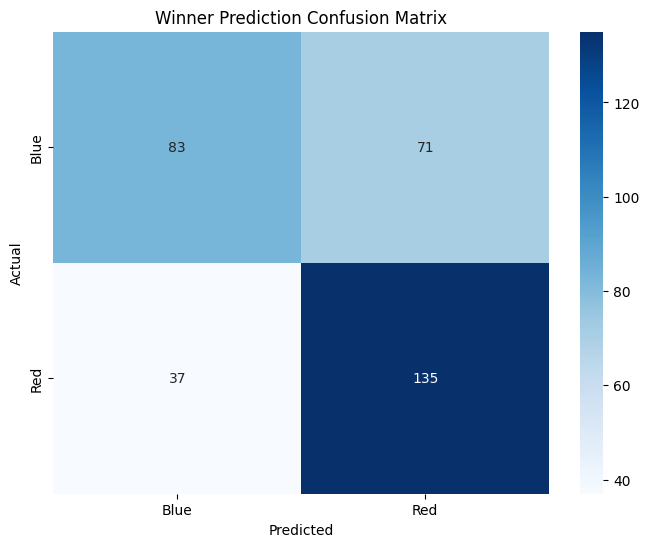

In [28]:
# Accuracy
accuracy_winner = accuracy_score(y_test_winner, y_pred_winner)
#print(f"Winner Model Accuracy: {accuracy_winner:.2f}")
display(HTML(f"<h3>Winner Model Accuracy: {accuracy_winner:.2f}</h3>"))

# Convert classification report to DataFrame
report = classification_report(y_test_winner, y_pred_winner, output_dict=True)
classification_df = pd.DataFrame(report).transpose()

# Display Classification Report as a Table
#print("Winner Model Classification Report:")
display(HTML("<h3>Winner Model Classification Report:</h3>"))
display(classification_df)

# Confusion Matrix as a Heatmap
# Blue = 0 and Red =1
cm_winner = confusion_matrix(y_test_winner, y_pred_winner)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_winner, annot=True, fmt='d', cmap='Blues', xticklabels=["Blue", "Red"], yticklabels=["Blue", "Red"])
plt.title("Winner Prediction Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

###**7.2 Method Model Evaluation**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1.000000
1,0.851064,0.963855,0.903955,83.000000
2,0.000000,0.000000,0.000000,1.000000
4,1.000000,0.021277,0.041667,47.000000
5,0.933333,0.763636,0.840000,55.000000
6,0.747312,1.000000,0.855385,139.000000
accuracy,0.803681,0.803681,0.803681,0.803681
macro avg,0.588618,0.458128,0.440168,326.000000
weighted avg,0.836957,0.803681,0.742592,326.000000


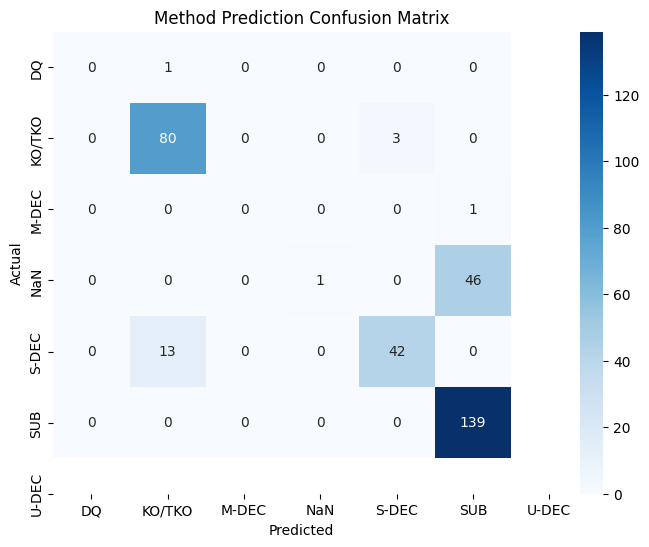

In [29]:
# Accuracy
accuracy_method = accuracy_score(y_test_method, y_pred_method)
display(HTML(f"<h3>Method Model Accuracy: {accuracy_method:.2f}</h3>"))

# Convert classification report to DataFrame
report_method = classification_report(y_test_method, y_pred_method, output_dict=True)
classification_method_df = pd.DataFrame(report_method).transpose()

# Display Classification Report as a Table
display(HTML("<h3>Method Model Classification Report:</h3>"))
display(classification_method_df)

# Confusion Matrix as a Heatmap
cm_method = confusion_matrix(y_test_method, y_pred_method)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_method, annot=True, fmt='d', cmap='Blues',
            xticklabels=["DQ", "KO/TKO",  "M-DEC", "NaN", "S-DEC", "SUB", "U-DEC"],
            yticklabels=["DQ", "KO/TKO",  "M-DEC", "NaN", "S-DEC", "SUB", "U-DEC"])
plt.title("Method Prediction Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

###**7.3 Round Model Evaluation**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
1,1.000000,0.984848,0.992366,66.00000
2,0.851852,1.000000,0.920000,46.00000
3,0.979058,0.973958,0.976501,192.00000
4,0.000000,0.000000,0.000000,3.00000
5,1.000000,0.842105,0.914286,19.00000
accuracy,0.963190,0.963190,0.963190,0.96319
macro avg,0.766182,0.760182,0.760631,326.00000
weighted avg,0.957559,0.963190,0.959128,326.00000


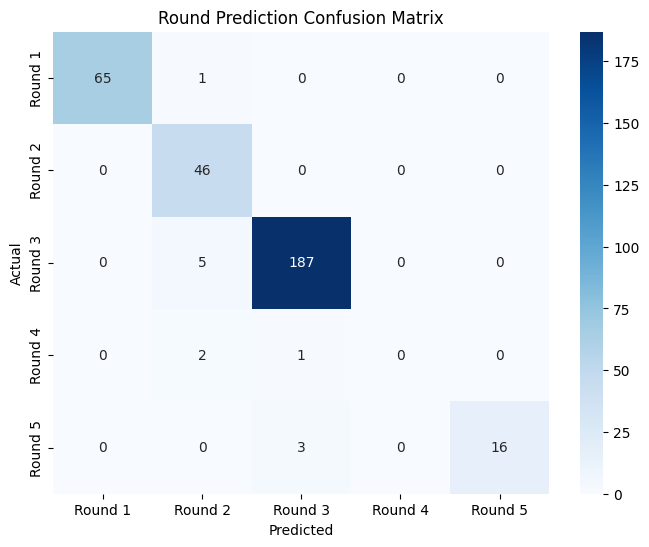

In [30]:
# Accuracy
accuracy_round = accuracy_score(y_test_round, y_pred_round)
display(HTML(f"<h3>Round Model Accuracy: {accuracy_round:.2f}</h3>"))

# Convert classification report to DataFrame
report_round = classification_report(y_test_round, y_pred_round, output_dict=True)
classification_round_df = pd.DataFrame(report_round).transpose()

# Display Classification Report as a Table
display(HTML("<h3>Round Model Classification Report:</h3>"))
display(classification_round_df)

# Confusion Matrix as a Heatmap
cm_round = confusion_matrix(y_test_round, y_pred_round)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_round, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Round 1", "Round 2", "Round 3", "Round 4", "Round 5"],
            yticklabels=["Round 1", "Round 2", "Round 3", "Round 4", "Round 5"])
plt.title("Round Prediction Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()